In [80]:
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from collections import defaultdict
import wordcloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import *
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler


In [183]:
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')
#train = pd.read_csv('train_cleaned_lite.csv')
#test = pd.read_csv('test_cleaned_lite.csv')

In [184]:
train['text'] = train['text'].astype(str)
test['text'] = test['text'].astype(str)

labels = train['target']
print('targets shape', labels.shape)

targets shape (7613,)


In [185]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train, labels, test_size = 0.2, stratify=labels)
X_train.shape
X_val.shape
y_train.shape
y_val.shape

(6090, 9)

(1523, 9)

(6090,)

(1523,)

#### Tokenizing

In [186]:
for i in [X_train, X_val, test]:
    i['text'] = i['text'].astype(str)


X_train_text = [i for i in X_train['text']]
X_val_text = [i for i in X_val['text']]
test_text = [i for i in test['text']]

In [187]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train_text)

print(len(tokenizer.word_index), 'unique tokens')

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
test_seq = tokenizer.texts_to_sequences(test_text)

11052 unique tokens


In [188]:
X_train_data = pad_sequences(X_train_seq)
X_val_data = pad_sequences(X_val_seq, X_train_data.shape[1])
test_data = pad_sequences(test_seq, X_train_data.shape[1])

In [189]:
X_train_data.shape
X_val_data.shape
test_data.shape

(6090, 23)

(1523, 23)

(3263, 23)

### Meta-feature scaling

In [190]:
scaler = StandardScaler()
scaler.fit(X_train.iloc[:, 2:])

meta_train = scaler.transform(X_train.iloc[:, 2:])
meta_val = scaler.transform(X_val.iloc[:, 2:])
meta_test = scaler.transform(test.iloc[:, 1:])

StandardScaler()

In [191]:
meta_train.shape
meta_val.shape
meta_test.shape

(6090, 7)

(1523, 7)

(3263, 7)

#### Functions

In [192]:
def loss_acc_plot(history):
    scores = pd.DataFrame(history.history)
    scores[['loss', 'val_loss']].plot();
    scores[['accuracy', 'val_accuracy']].plot();
    #scores[['f1_score', 'val_f1_score']].plot();

answers = pd.read_csv('answer key.csv')
y_true = answers['target']

def kaggle(model, filename=''):
    y_pred = (model.predict([test_data, meta_test]) > 0.5).astype(int)
    print('\nf1 score is:', f1_score(y_true, y_pred, average='macro'))
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    
    if filename != '':
        submission=pd.read_csv('sample_submission.csv')
        submission['target']=y_pred
        submission.to_csv(filename+'.csv', index=False)

In [193]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.5, 
                              verbose = 1, 
                              patience = 4,                        
                              min_lr = 0.0001)

def model_process(model, n_epochs=20, model_name='', filename=''):
    model.summary()
    
    checkpointer = ModelCheckpoint(filepath = model_name+'.hdf5', 
                                   save_best_only=True,
                                   save_weights_only=True,
                                   monitor='val_loss')

    history = model.fit(x=[X_train_data, meta_train],
                        y=y_train,
                        epochs = n_epochs,
                        verbose=1,
                        callbacks=[checkpointer, reduce_lr],
                        validation_data = ([X_val_data, meta_val], y_val)
                       )
    
    loss_acc_plot(history)
    
    model.load_weights(model_name+'.hdf5')
    
    loss, acc = model.evaluate([X_val_data, meta_val], y_val)
    print('\nModel accuracy on validation set = ', acc)
    print('\nModel loss on validation set = ', loss)
    
    y_val_pred = (model.predict([X_val_data, meta_val]) > 0.5).astype(int)
    print('\nModel F1 on validation set = ', f1_score(y_val, y_val_pred, average='macro'))
    
    kaggle(model, filename)

# SimpleRNN

#### 1 SimpleRNN layer

In [200]:
def simpleRNN(dropout_val):
            
    #define inputs
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    #Embed
    word_index = len(tokenizer.word_index)
    input_size = test_data.shape[1]
    
    emb = Embedding(input_dim=word_index+1, 
                    output_dim=40,
                    input_length = input_size)(nlp_input)
    emb = SpatialDropout1D(dropout_val)(emb)

    #SimpleRNN
  #  nlp_out = SimpleRNN(40, dropout=dropout_val, return_sequences=True)(emb)     
    nlp_out = SimpleRNN(30, dropout=dropout_val)(emb)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout_val)(x)
    x = (Dense(20, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(dropout_val)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input, meta_input_train], outputs = preds)
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.002), metrics = ['accuracy'])
    
    return model

Model: "functional_499"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 23, 40)       442120      nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_464 (SpatialD (None, 23, 40)       0           embedding_39[0][0]               
__________________________________________________________________________________________________
simple_rnn_12 (SimpleRNN)       (None, 30)           2130        spatial_dropout1d_464[0][0]      
_____________________________________________________________________________________

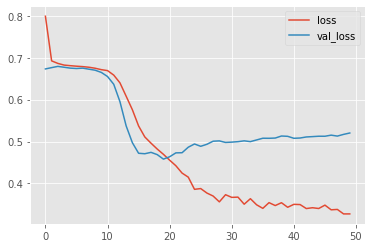

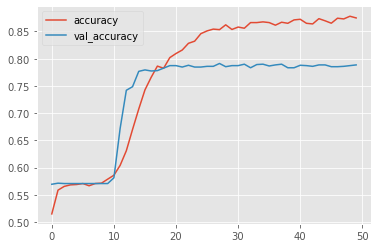

In [201]:
model1 = simpleRNN(0.7)
model_process(model1, 50, model_name='01 simple RNN', filename='01 simple RNN')

#### 2 SimpleRNN layers

In [219]:
def simpleRNN():
    rnn_dropout = 0.5
    dropout = 0.0
    spatial_dropout = 0.1
    
    lr = 0.0002
    optimizer = RMSprop
    
    layer1 = 90
    layer2 = 50
    dense_units = 100
    
    embed_output = 20
        
    #model
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    word_index = len(tokenizer.word_index)
    input_size = test_data.shape[1]
    
    emb = Embedding(input_dim=word_index+1, 
                    output_dim=embed_output,
                    input_length = input_size)(nlp_input)
    emb = SpatialDropout1D(spatial_dropout)(emb)

    nlp_out = SimpleRNN(layer1, dropout=rnn_dropout, return_sequences=True)(emb)
    
    nlp_out = SpatialDropout1D(spatial_dropout)(nlp_out)
    nlp_out = SimpleRNN(layer2, dropout=rnn_dropout)(nlp_out)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(dense_units, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer(lr), metrics = ['accuracy'])

    return model

Model: "functional_519"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 23, 20)       221060      nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_478 (SpatialD (None, 23, 20)       0           embedding_49[0][0]               
__________________________________________________________________________________________________
simple_rnn_17 (SimpleRNN)       (None, 23, 90)       9990        spatial_dropout1d_478[0][0]      
_____________________________________________________________________________________

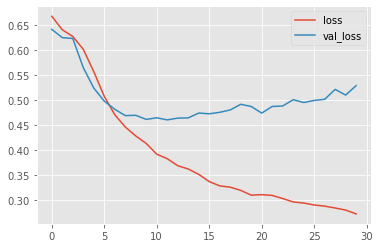

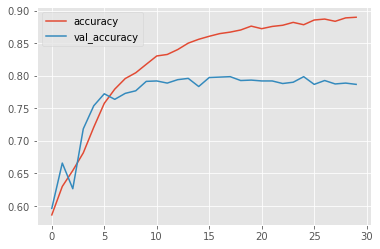

In [220]:
model1 = simpleRNN()
model_process(model1, 30, '02 dual simple RNN', filename='01 dual simple RNN')

# LSTM

In [206]:
def m2_lstm(dropout_val):
            
    #define inputs
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    #Embed
    word_index = len(tokenizer.word_index)
    input_size = test_data.shape[1]
    
    emb = Embedding(input_dim=word_index+1, 
                    output_dim=40,
                    input_length = input_size)(nlp_input)
    emb = SpatialDropout1D(0.4)(emb)

    nlp_out = LSTM(50, dropout=0.3)(emb)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout_val)(x)
    x = (Dense(30, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(dropout_val)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(0.0004), metrics = ['accuracy'])
    
    return model

Model: "functional_507"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_43 (Embedding)        (None, 23, 40)       442120      nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_468 (SpatialD (None, 23, 40)       0           embedding_43[0][0]               
__________________________________________________________________________________________________
lstm_460 (LSTM)                 (None, 50)           18200       spatial_dropout1d_468[0][0]      
_____________________________________________________________________________________

Epoch 38/50
191/191 [==============================] - 1s 7ms/step - loss: 0.3442 - accuracy: 0.8650 - val_loss: 0.4918 - val_accuracy: 0.7912
Epoch 39/50
191/191 [==============================] - 1s 7ms/step - loss: 0.3447 - accuracy: 0.8716 - val_loss: 0.4910 - val_accuracy: 0.7919
Epoch 40/50
191/191 [==============================] - 1s 7ms/step - loss: 0.3374 - accuracy: 0.8749 - val_loss: 0.4962 - val_accuracy: 0.7912
Epoch 41/50
191/191 [==============================] - 1s 8ms/step - loss: 0.3438 - accuracy: 0.8704 - val_loss: 0.4968 - val_accuracy: 0.7925
Epoch 42/50
191/191 [==============================] - 1s 7ms/step - loss: 0.3393 - accuracy: 0.8690 - val_loss: 0.4964 - val_accuracy: 0.7919
Epoch 43/50
191/191 [==============================] - 1s 8ms/step - loss: 0.3379 - accuracy: 0.8693 - val_loss: 0.4951 - val_accuracy: 0.7919
Epoch 44/50
191/191 [==============================] - 1s 7ms/step - loss: 0.3347 - accuracy: 0.8724 - val_loss: 0.4965 - val_accuracy: 0.7925

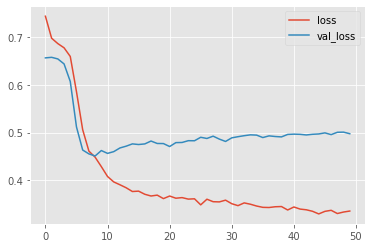

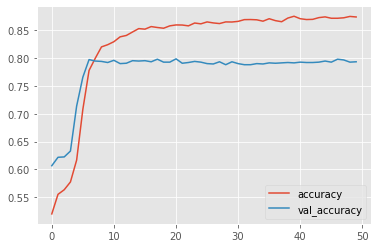

In [207]:
model2 = m2_lstm(0.6)
model_process(model2, 50, '03 simple LSTM', filename='03 simple LSTM')

# Bidirectional LSTM

In [208]:
def m3_bidirectionallstm():
    LSTM_dropout = 0.3
    dropout = 0.3
    spatial_dropout = 0.8
    
    lr = 0.004
    optimizer = Adam
    
    LSTM1 = 100
    dense_units = 100
    
    embed_output = 30
    
            
 #model
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    word_index = len(tokenizer.word_index)
    input_size = test_data.shape[1]
    
    emb = Embedding(input_dim=word_index+1, 
                    output_dim=embed_output,
                    input_length = input_size)(nlp_input)
    emb = SpatialDropout1D(spatial_dropout)(emb)

    nlp_out = Bidirectional(LSTM(LSTM1, dropout=LSTM_dropout))(emb)   
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(dense_units, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer(lr), metrics = ['accuracy'])
    
    return model

Model: "functional_509"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 23, 30)       331590      nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_469 (SpatialD (None, 23, 30)       0           embedding_44[0][0]               
__________________________________________________________________________________________________
bidirectional_448 (Bidirectiona (None, 200)          104800      spatial_dropout1d_469[0][0]      
_____________________________________________________________________________________

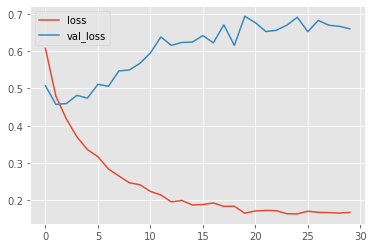

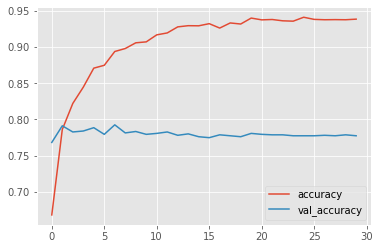

In [209]:
model3 = m3_bidirectionallstm()
model_process(model3, 30, '04 bidirectional LSTM', filename='04 bidirectional LSTM')

# Bidirectional 2-layer LSTM

In [215]:
def m4_bidirectional_dual_lstm():
            
    LSTM_dropout = 0.4
    dropout = 0.4
    spatial_dropout = 0.6
    
    lr = 0.0003
    optimizer = RMSprop
    
    LSTM1 = 60
    LSTM2 = 80
    dense_units = 80
    
    embed_output = 90
    
            
 #model
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    word_index = len(tokenizer.word_index)
    input_size = test_data.shape[1]
    
    emb = Embedding(input_dim=word_index+1, 
                    output_dim=embed_output,
                    input_length = input_size)(nlp_input)
    emb = SpatialDropout1D(spatial_dropout)(emb)

    nlp_out = Bidirectional(LSTM(LSTM1, dropout=LSTM_dropout, return_sequences=True))(emb) 
    nlp_out = SpatialDropout1D(spatial_dropout)(nlp_out)
    nlp_out = Bidirectional(LSTM(LSTM2, dropout=LSTM_dropout))(nlp_out)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(dense_units, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer(lr), metrics = ['accuracy'])
    
    return model

Model: "functional_515"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 23, 90)       994770      nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_474 (SpatialD (None, 23, 90)       0           embedding_47[0][0]               
__________________________________________________________________________________________________
bidirectional_451 (Bidirectiona (None, 23, 120)      72480       spatial_dropout1d_474[0][0]      
_____________________________________________________________________________________

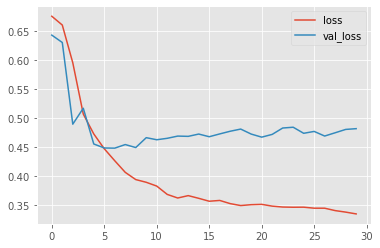

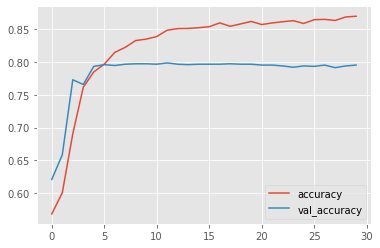

In [216]:
model4 = m4_bidirectional_dual_lstm()
model_process(model4, 30, '05 bidirectional dual lstm', '05 bidirectional dual lstm')

# LSTM with GloVe

In [145]:
embeddings_index = {}
with open('glove.6B/glove.6B.200d.txt','r', encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

400001it [00:18, 21238.07it/s]


In [150]:
EMBEDDING_DIM = 200  
word_index = tokenizer.word_index

#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 15163/15163 [00:00<00:00, 582678.85it/s]

Our embedded matrix is of dimension (15164, 200)


In [151]:
embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = 23, trainable = False)  

In [235]:
def m5_glove():
            
    #define inputs
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(0.4)(emb)

    nlp_out = Bidirectional(LSTM(50, 
                                 dropout=0.4, kernel_initializer = 'orthogonal',
                                 ))(emb)     
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    #x = Dropout(0.1)(x)
    #x = (Dense(60, 
   #            activation = 'relu'
   #           ))(x)
    
    #add output layer
    x = Dropout(0.4)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(0.004), metrics = ['accuracy'])
    
    return model

In [ ]:
model5 = m5_glove()
model_process(model5, 50, '07 GloVe single LSTM', filename='07 GloVe single LSTM')

# GloVe dual LSTM

In [229]:
def m6_glove2():
            
    #define inputs
    nlp_input = Input(shape = (23,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    

    emb = embedding(nlp_input)
    emb = SpatialDropout1D(0.1)(emb)

    
    nlp_out = Bidirectional(LSTM(70, 
                                 dropout=0.4,
                                 return_sequences=True))(emb)    
    
    nlp_out = SpatialDropout1D(0.1)(nlp_out)
    
    nlp_out = Bidirectional(LSTM(50, 
                                 dropout=0.4))(emb)    
    
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(0.6)(x)
    x = (Dense(90, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(0.6)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.005), metrics = ['accuracy'])
    
    return model

# model tuning

In [167]:
import optuna

In [173]:
def objective(trial):
    LSTM_dropout = trial.suggest_discrete_uniform('dropout', 0.0, 0.8, 0.1)
    dropout = trial.suggest_discrete_uniform('dropout', 0.0, 0.8, 0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = trial.suggest_categorical("optimizer", [Adam, RMSprop])
    
    LSTM1 = trial.suggest_int('units1', 20, 200, step=10)
    LSTM2 = trial.suggest_int('units2', 20, 200, step=10)
    dense_units = trial.suggest_int('units3', 20, 200, step=10)
    
    
    
    nlp_input = Input(shape = (40,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    nlp_out = Bidirectional(LSTM(LSTM1, 
                                 dropout=LSTM_dropout,
                                 return_sequences=True))(emb)    
    
    nlp_out = SpatialDropout1D(dropout)(nlp_out)
    
    nlp_out = Bidirectional(LSTM(LSTM2, 
                                 dropout=LSTM_dropout))(emb)    
    
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(dense_units, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer(lr), metrics = ['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.5, 
                              verbose = False, 
                              patience = 4,                        
                              min_lr = 0.0001)
    
    model.fit(x=[X_train_data, meta_train],
                        y=y_train,
                        epochs = 30,
                        verbose=False,
                        callbacks=[reduce_lr],
                        validation_data = ([X_val_data, meta_val], y_val),
                        shuffle=True
                       )
    y_pred = (model.predict([test_data, meta_test]) > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

In [174]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-08-22 16:51:04,521] A new study created in memory with name: no-name-2a44ce95-fde1-44ce-9cec-1f8d98d9f70e
[I 2021-08-22 16:51:39,653] Trial 0 finished with value: 0.8003066407696942 and parameters: {'dropout': 0.4, 'lr': 0.0024002985508868833, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 160, 'units2': 100, 'units3': 130}. Best is trial 0 with value: 0.8003066407696942.
[I 2021-08-22 16:52:28,498] Trial 1 finished with value: 0.36463379803071716 and parameters: {'dropout': 0.8, 'lr': 6.114977604969302e-05, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 140, 'units2': 110, 'units3': 50}. Best is trial 0 with value: 0.8003066407696942.
[I 2021-08-22 16:53:14,854] Trial 2 finished with value: 0.7609989096779143 and parameters: {'dropout': 0.30000000000000004, 'lr': 0.03015223198850489, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 150, 'units2': 180, 'units3': 120}. Best is tri

[I 2021-08-22 17:08:18,948] Trial 25 finished with value: 0.7999453553664693 and parameters: {'dropout': 0.4, 'lr': 0.0024685479486593366, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'units1': 160, 'units2': 40, 'units3': 170}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:09:02,298] Trial 26 finished with value: 0.6585403725304242 and parameters: {'dropout': 0.6000000000000001, 'lr': 0.013284269834185923, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 110, 'units2': 130, 'units3': 120}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:09:37,175] Trial 27 finished with value: 0.8039306452747039 and parameters: {'dropout': 0.30000000000000004, 'lr': 0.00037571748356424493, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'units1': 190, 'units2': 70, 'units3': 70}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:10:21,701] Trial 28 finished

[I 2021-08-22 17:27:41,961] Trial 51 finished with value: 0.7964874535790741 and parameters: {'dropout': 0.5, 'lr': 0.0012320563994942405, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 130, 'units2': 110, 'units3': 90}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:28:29,231] Trial 52 finished with value: 0.8016845546521477 and parameters: {'dropout': 0.5, 'lr': 0.0018357515854378092, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 140, 'units2': 90, 'units3': 100}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:29:16,320] Trial 53 finished with value: 0.7886270323087581 and parameters: {'dropout': 0.6000000000000001, 'lr': 0.0014818211760892059, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 20, 'units2': 110, 'units3': 110}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:30:07,481] Trial 54 finished with value: 0.7903854050195

[I 2021-08-22 17:45:54,394] Trial 77 finished with value: 0.7977484611714651 and parameters: {'dropout': 0.30000000000000004, 'lr': 0.004102469501908456, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 140, 'units2': 90, 'units3': 100}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:46:40,347] Trial 78 finished with value: 0.7688387829634425 and parameters: {'dropout': 0.4, 'lr': 0.04126389260856586, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 120, 'units2': 130, 'units3': 90}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:47:15,022] Trial 79 finished with value: 0.7998054038829607 and parameters: {'dropout': 0.5, 'lr': 0.0009922814083197452, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units1': 160, 'units2': 80, 'units3': 120}. Best is trial 21 with value: 0.8083996467460235.
[I 2021-08-22 17:47:59,965] Trial 80 finished with value: 0.801213530609788

In [172]:
trial = study.best_trial
trial.params

{'dropout': 0.4452773316562999,
 'lr': 0.0025723160267613373,
 'optimizer': tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop,
 'units': 120}

In [175]:
trial = study.best_trial
trial.params

{'dropout': 0.4,
 'lr': 0.002381402814398891,
 'optimizer': tensorflow.python.keras.optimizer_v2.adam.Adam,
 'units1': 130,
 'units2': 110,
 'units3': 90}